# COMP5329 - Deep Learning 

## Tutorial 4 - Network structures

**Semester 1, 2018**

**Objectives:**

* To learn about how to build AlexNet and use a pretrained AlexNet to implement classification. 
* To learn about how to finetune AlexNet with your datasets.

**Instructions:**

* Install the opencv library by typing command 'pip install opencv-python' under your tensorflow environment.
* Exercises to be completed on IPython notebook such as web-based TMPNB Ipython notebook(https://tmpnb.org).
* Go to File->Open. Drag and drop "Network_structures.ipynb"(with '') file to the home interface and click upload.
* To run the cell you can press Ctrl-Enter or hit the Play button at the top. 

Lecturers: Chang Xv

Tutors: 


## AlexNet

The first convolutional layer filters the 227×227×3 input image with 96 kernels of size 11×11×3 with a stride of 4 pixels. The second convolutional layer takes the output of the first convolutional layer as input and filters it with 256 kernels of size 5 × 5 × 96. The third, fourth, and fifth convolutional layers are connected to one another without any intervening pooling or normalization layers. The third convolutional layer has 384 kernels of size 3 × 3 × 256 connected to the (normalized, pooled) outputs of the second convolutional layer. The fourth convolutional layer has 384 kernels of size 3 × 3 × 384 , and the fifth convolutional layer has 256 kernels of size 3 × 3 × 384. The fully-connected layers have 4096 neurons each.

## Definition of AlexNet

This part shows the code of building an AlexNet and how to initial your net with pretrained weights.
The structure of AlexNet shows below:
![Flowchart](alexnet.png)
Note that there is a 3X3 max pooling with stride 2 after the conv5 layer, therefore, the number of neuron that connects to the fc6 layer is 6X6X256.

In [1]:
import tensorflow as tf
import numpy as np


class AlexNet(object):
    """Implementation of the AlexNet."""

    def __init__(self, x, keep_prob, num_classes, skip_layer,
                 weights_path='DEFAULT'):
        """Create the graph of the AlexNet model.

        Args:
            x: Placeholder for the input tensor.
            keep_prob: Dropout probability.
            num_classes: Number of classes in the dataset.
            skip_layer: List of names of the layer, that get trained from
                scratch
            weights_path: Complete path to the pretrained weight file, if it
                isn't in the same folder as this code
        """
        # Parse input arguments into class variables
        self.X = x
        self.NUM_CLASSES = num_classes
        self.KEEP_PROB = keep_prob
        self.SKIP_LAYER = skip_layer

        if weights_path == 'DEFAULT':
            self.WEIGHTS_PATH = 'bvlc_alexnet.npy'
        else:
            self.WEIGHTS_PATH = weights_path

        # Call the create function to build the computational graph of AlexNet
        self.create()

    def create(self):
        """Create the network graph."""
        # 1st Layer: Conv (w ReLu) -> Lrn -> Pool
        conv1 = conv(self.X, 11, 11, 96, 4, 4, padding='VALID', name='conv1')
        norm1 = lrn(conv1, 2, 1e-05, 0.75, name='norm1')
        pool1 = max_pool(norm1, 3, 3, 2, 2, padding='VALID', name='pool1')
        
        # 2nd Layer: Conv (w ReLu)  -> Lrn -> Pool with 2 groups
        conv2 = conv(pool1, 5, 5, 256, 1, 1, groups=2, name='conv2')
        norm2 = lrn(conv2, 2, 1e-05, 0.75, name='norm2')
        pool2 = max_pool(norm2, 3, 3, 2, 2, padding='VALID', name='pool2')
        
        # 3rd Layer: Conv (w ReLu)
        conv3 = conv(pool2, 3, 3, 384, 1, 1, name='conv3')

        # 4th Layer: Conv (w ReLu) splitted into two groups
        conv4 = conv(conv3, 3, 3, 384, 1, 1, groups=2, name='conv4')

        # 5th Layer: Conv (w ReLu) -> Pool splitted into two groups
        conv5 = conv(conv4, 3, 3, 256, 1, 1, groups=2, name='conv5')
        pool5 = max_pool(conv5, 3, 3, 2, 2, padding='VALID', name='pool5')

        # 6th Layer: Flatten -> FC (w ReLu) -> Dropout
        flattened = tf.reshape(pool5, [-1, 6*6*256])
        fc6 = fc(flattened, 6*6*256, 4096, name='fc6')
        dropout6 = dropout(fc6, self.KEEP_PROB)

        # 7th Layer: FC (w ReLu) -> Dropout
        fc7 = fc(dropout6, 4096, 4096, name='fc7')
        dropout7 = dropout(fc7, self.KEEP_PROB)

        # 8th Layer: FC and return unscaled activations
        self.fc8 = fc(dropout7, 4096, self.NUM_CLASSES, relu=False, name='fc8')

    def load_initial_weights(self, session):
        #Load weights from file into network.
        
        # Load the weights into memory
        weights_dict = np.load(self.WEIGHTS_PATH, encoding='bytes').item()

        # Loop over all layer names stored in the weights dict
        for op_name in weights_dict:

            # Check if layer should be trained from scratch
            if op_name not in self.SKIP_LAYER:

                with tf.variable_scope(op_name, reuse=True):

                    # Assign weights/biases to their corresponding tf variable
                    for data in weights_dict[op_name]:

                        # Biases
                        if len(data.shape) == 1:
                            var = tf.get_variable('biases', trainable=False)
                            session.run(var.assign(data))

                        # Weights
                        else:
                            var = tf.get_variable('weights', trainable=False)
                            session.run(var.assign(data))


def conv(x, filter_height, filter_width, num_filters, stride_y, stride_x, name,
         padding='SAME', groups=1):
    #Create a convolution layer.

    # Get number of input channels
    input_channels = int(x.get_shape()[-1])

    # Create lambda function for the convolution
    convolve = lambda i, k: tf.nn.conv2d(i, k,
                                         strides=[1, stride_y, stride_x, 1],
                                         padding=padding)

    with tf.variable_scope(name) as scope:
        # Create tf variables for the weights and biases of the conv layer
        weights = tf.get_variable('weights', shape=[filter_height,
                                                    filter_width,
                                                    input_channels/groups,
                                                    num_filters])
        biases = tf.get_variable('biases', shape=[num_filters])

    if groups == 1:
        conv = convolve(x, weights)

    # In the cases of multiple groups, split inputs & weights and
    else:
        # Split input and weights and convolve them separately
        input_groups = tf.split(axis=3, num_or_size_splits=groups, value=x)
        weight_groups = tf.split(axis=3, num_or_size_splits=groups,
                                 value=weights)
        output_groups = [convolve(i, k) for i, k in zip(input_groups, weight_groups)]

        # Concat the convolved output together again
        conv = tf.concat(axis=3, values=output_groups)

    # Add biases
    bias = tf.reshape(tf.nn.bias_add(conv, biases), tf.shape(conv))

    # Apply relu function
    relu = tf.nn.relu(bias, name=scope.name)

    return relu


def fc(x, num_in, num_out, name, relu=True):
    """Create a fully connected layer."""
    with tf.variable_scope(name) as scope:

        # Create tf variables for the weights and biases
        weights = tf.get_variable('weights', shape=[num_in, num_out],
                                  trainable=True)
        biases = tf.get_variable('biases', [num_out], trainable=True)

        # Matrix multiply weights and inputs and add bias
        act = tf.nn.xw_plus_b(x, weights, biases, name=scope.name)

    if relu:
        # Apply ReLu non linearity
        relu = tf.nn.relu(act)
        return relu
    else:
        return act


def max_pool(x, filter_height, filter_width, stride_y, stride_x, name,
             padding='SAME'):
    """Create a max pooling layer."""
    return tf.nn.max_pool(x, ksize=[1, filter_height, filter_width, 1],
                          strides=[1, stride_y, stride_x, 1],
                          padding=padding, name=name)


def lrn(x, radius, alpha, beta, name, bias=1.0):
    """Create a local response normalization layer."""
    return tf.nn.local_response_normalization(x, depth_radius=radius,
                                              alpha=alpha, beta=beta,
                                              bias=bias, name=name)


def dropout(x, keep_prob):
    """Create a dropout layer."""
    return tf.nn.dropout(x, keep_prob)

### Classify images with pretrained AlexNet
Using the pretrained AlexNet for image classification.
First, load the images for classification and show it.

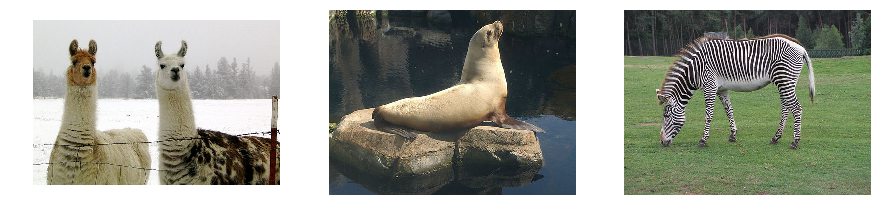

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


#mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()

#Modify the image_dir to your local path to images
image_dir = os.path.join(current_dir, 'images')

%matplotlib inline

#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpeg')]
#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

Then we can build the AlexNet by using the alexnet class difined above.

In [3]:
#load the classes names of ImageNet dataset
from caffe_classes import class_names

#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 227, 227, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = AlexNet(x, keep_prob, 1000, [])

#define activation of last layer as score
score = model.fc8

#create op to calculate softmax 
softmax = tf.nn.softmax(score)

### Image classification with pretrained AlexNet

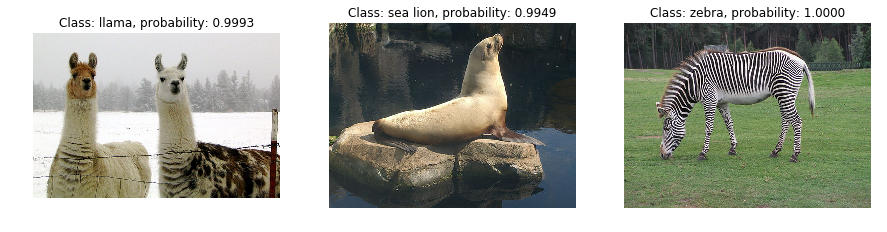

In [4]:
with tf.Session() as sess:
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights from bvlc_alexnet.npy into the model
    model.load_initial_weights(sess)
    
    # Create figure handle
    fig2 = plt.figure(figsize=(15,6))
    
    # Loop over all images
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (227,227))
        
        # Subtract the ImageNet mean
        img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,227,227,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        # Plot image with class name and prob in the title
        fig2.add_subplot(1,3,i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
        plt.axis('off')

The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

### Finetune the AlexNet with new dataset

Since the demand of data for AlexNet finetune is too large, we only provide the codes here. You can finetune the network on your downloaded datasets by using this code. The common image dataset for classification task involves ImageNet, Cifar10 and Cifar100.

To run this code, first run the AlexNet difinition part and then run this part. Make sure you have already saved the path and image names in your train.txt and val.txt files. Modify the path in the code to your own path.

In [6]:
import os

import numpy as np
import tensorflow as tf

from datagenerator import ImageDataGenerator
from datetime import datetime
from tensorflow.contrib.data import Iterator

"""
Configuration Part.
"""

# Path to the textfiles for the trainings and validation set
train_file = '/path/to/train.txt'
val_file = '/path/to/val.txt'

# Learning params
learning_rate = 0.01
num_epochs = 10
batch_size = 128

# Network params
dropout_rate = 0.5
num_classes = 2
train_layers = ['fc8', 'fc7', 'fc6']

# How often we want to write the tf.summary data to disk
display_step = 20

# Path for tf.summary.FileWriter and to store model checkpoints
filewriter_path = "/tmp/finetune_alexnet/tensorboard"
checkpoint_path = "/tmp/finetune_alexnet/checkpoints"

"""
Main Part of the finetuning Script.
"""

# Create parent path if it doesn't exist
if not os.path.isdir(checkpoint_path):
    os.mkdir(checkpoint_path)

# Place data loading and preprocessing on the cpu
with tf.device('/cpu:0'):
    tr_data = ImageDataGenerator(train_file,
                                 mode='training',
                                 batch_size=batch_size,
                                 num_classes=num_classes,
                                 shuffle=True)
    val_data = ImageDataGenerator(val_file,
                                  mode='inference',
                                  batch_size=batch_size,
                                  num_classes=num_classes,
                                  shuffle=False)

    # create an reinitializable iterator given the dataset structure
    iterator = Iterator.from_structure(tr_data.data.output_types,
                                       tr_data.data.output_shapes)
    next_batch = iterator.get_next()

# Ops for initializing the two different iterators
training_init_op = iterator.make_initializer(tr_data.data)
validation_init_op = iterator.make_initializer(val_data.data)

# TF placeholder for graph input and output
x = tf.placeholder(tf.float32, [batch_size, 227, 227, 3])
y = tf.placeholder(tf.float32, [batch_size, num_classes])
keep_prob = tf.placeholder(tf.float32)

# Initialize model
model = AlexNet(x, keep_prob, num_classes, train_layers)

# Link variable to model output
score = model.fc8

# List of trainable variables of the layers we want to train
var_list = [v for v in tf.trainable_variables() if v.name.split('/')[0] in train_layers]

# Op for calculating the loss
with tf.name_scope("cross_ent"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=score,
                                                                  labels=y))

# Train op
with tf.name_scope("train"):
    # Get gradients of all trainable variables
    gradients = tf.gradients(loss, var_list)
    gradients = list(zip(gradients, var_list))

    # Create optimizer and apply gradient descent to the trainable variables
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.apply_gradients(grads_and_vars=gradients)

# Add gradients to summary
for gradient, var in gradients:
    tf.summary.histogram(var.name + '/gradient', gradient)

# Add the variables we train to the summary
for var in var_list:
    tf.summary.histogram(var.name, var)

# Add the loss to summary
tf.summary.scalar('cross_entropy', loss)


# Evaluation op: Accuracy of the model
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(score, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Add the accuracy to the summary
tf.summary.scalar('accuracy', accuracy)

# Merge all summaries together
merged_summary = tf.summary.merge_all()

# Initialize the FileWriter
writer = tf.summary.FileWriter(filewriter_path)

# Initialize an saver for store model checkpoints
saver = tf.train.Saver()

# Get the number of training/validation steps per epoch
train_batches_per_epoch = int(np.floor(tr_data.data_size/batch_size))
val_batches_per_epoch = int(np.floor(val_data.data_size / batch_size))

# Start Tensorflow session
with tf.Session() as sess:

    # Initialize all variables
    sess.run(tf.global_variables_initializer())

    # Add the model graph to TensorBoard
    writer.add_graph(sess.graph)

    # Load the pretrained weights into the non-trainable layer
    model.load_initial_weights(sess)

    print("{} Start training...".format(datetime.now()))
    print("{} Open Tensorboard at --logdir {}".format(datetime.now(),
                                                      filewriter_path))

    # Loop over number of epochs
    for epoch in range(num_epochs):

        print("{} Epoch number: {}".format(datetime.now(), epoch+1))

        # Initialize iterator with the training dataset
        sess.run(training_init_op)

        for step in range(train_batches_per_epoch):

            # get next batch of data
            img_batch, label_batch = sess.run(next_batch)

            # And run the training op
            sess.run(train_op, feed_dict={x: img_batch,
                                          y: label_batch,
                                          keep_prob: dropout_rate})

            # Generate summary with the current batch of data and write to file
            if step % display_step == 0:
                s = sess.run(merged_summary, feed_dict={x: img_batch,
                                                        y: label_batch,
                                                        keep_prob: 1.})

                writer.add_summary(s, epoch*train_batches_per_epoch + step)

        # Validate the model on the entire validation set
        print("{} Start validation".format(datetime.now()))
        sess.run(validation_init_op)
        test_acc = 0.
        test_count = 0
        for _ in range(val_batches_per_epoch):

            img_batch, label_batch = sess.run(next_batch)
            acc = sess.run(accuracy, feed_dict={x: img_batch,
                                                y: label_batch,
                                                keep_prob: 1.})
            test_acc += acc
            test_count += 1
        test_acc /= test_count
        print("{} Validation Accuracy = {:.4f}".format(datetime.now(),
                                                       test_acc))
        print("{} Saving checkpoint of model...".format(datetime.now()))

        # save checkpoint of the model
        checkpoint_name = os.path.join(checkpoint_path,
                                       'model_epoch'+str(epoch+1)+'.ckpt')
        save_path = saver.save(sess, checkpoint_name)

        print("{} Model checkpoint saved at {}".format(datetime.now(),
                                                       checkpoint_name))

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/finetune_alexnet/checkpoints'

## Structure definition of more networks

For the structure of other networks such as ResNet, VGG and InceptionNets, visit https://github.com/tensorflow/models/tree/master/research/slim for more details.